In [38]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [18]:
DATASET_ROOT = Path('D:\\dataset\\flybyml_dataset')
data_root = DATASET_ROOT / "data"
image_root = DATASET_ROOT / "image"
meta_root = DATASET_ROOT / "meta"

# Integrity Check
see if all data, image and meta have corresponding session ids

In [19]:
# collect all possible session ids
session_ids = set()

for data_file in os.listdir(data_root):
    session_id = data_file.split(".")[0]
    session_ids.add(session_id)

for session_id in os.listdir(image_root):
    session_ids.add(session_id)

for meta_file in os.listdir(meta_root):
    session_id = meta_file.split(".")[0]
    session_ids.add(session_id)

In [20]:
# collect all orphan paths
orphan_paths = []

for session_id in session_ids:
    data_path = data_root / f"{session_id}.json"
    image_path = image_root / session_id
    meta_path = meta_root / f"{session_id}.json"

    temp = []
    if os.path.exists(data_path):
        temp.append(data_path)

    if os.path.exists(image_path):
        temp.append(image_path)

    if os.path.exists(meta_path):
        temp.append(meta_path)
    
    if len(temp) < 3:
        for path in temp:
            orphan_paths.append(path)
orphan_paths

[]

In [22]:
len(session_ids)

48

# Data Inspection

In [34]:
def load_data(session_id):
    with open(data_root / f"{session_id}.json", "r") as f:
        return json.load(f)

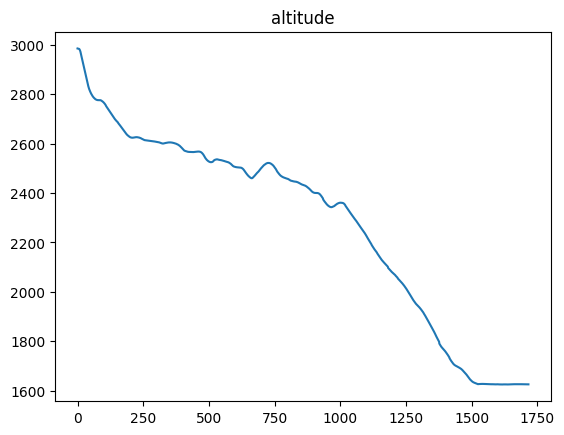

In [111]:
data = load_data(list(session_ids)[29])

alt = []
for datum in data:
    alt.append(datum['state']['position'][2])

t = np.arange(0, len(alt), 1)
plt.title('altitude')
plt.plot(t, alt)
plt.show()

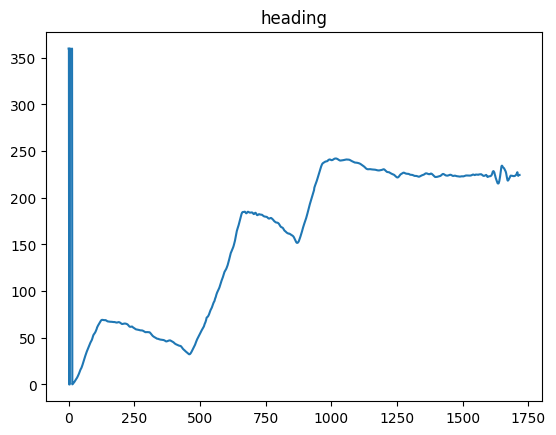

In [112]:
heading = []
for datum in data:
    heading.append(datum['state']['attitude'][2])
plt.title('heading')
plt.plot(t, heading)
plt.show()